# Vessel Classification on January Data

Since we do not have the capability to compare the classification here to a single row classification directly we will only do the voyage view for the entire monthlong dataset.

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [21]:
dir_path = './data/voyage_agg/'
all_files = os.listdir(dir_path)
all_files = [dir_path + f for f in all_files]
other_dir = './data/voyage_agg_sub/'
first = True
for f in all_files:
    temp = pd.read_csv(f)
    temp = temp[temp.VesselType.isin([37,51,35,30])]
    if first:
        temp.to_csv(other_dir + 'binary_set.csv',index=False)
        first = False
    else:
        temp.to_csv(other_dir + 'binary_set.csv',index=False,header=False,mode='a')
del temp

In [22]:
ais = pd.read_csv(other_dir + 'binary_set.csv')
ais = ais.dropna()
ais['VesselType'] = ais['VesselType'].astype(str)
ais.head()

,voyage_id,VesselName,MMSI,VesselType,LAT,LON,SOG,Heading,acceleration,bearing_rate
0,111111111#1546369891000,ALPHA KILO,111111111.0,37.0,26.406174,-80.068616,10.338889,511.0,0.001754,0.0
1,12#1546300949000,CLETUS,12.0,37.0,27.327062,-82.588948,0.176923,511.0,-0.000003,0.0
2,123456789#1546300835000,ODYSSEY,123456789.0,37.0,27.816843,-84.122288,0.365517,511.0,-0.000045,0.0
3,123456789#1546309954000,ODYSSEY,123456789.0,37.0,28.223083,-86.835283,0.000000,511.0,0.000000,0.0
4,123456789#1546310315000,ODYSSEY,123456789.0,37.0,28.255367,-86.081720,0.025000,511.0,-0.000089,0.0


In [23]:
ais.shape

(213289, 10)

In [24]:
ais.VesselName.nunique()

8734

## Decision Tree

In [25]:
features = ['LAT','LON','SOG','Heading', 'acceleration', 'bearing_rate']
df = ais.copy()
for feat in features:
    df = df[np.isfinite(df[feat])]
X_train = df[features]
Y_train = df['VesselType'].astype(str).tolist()
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=123)
dt_model = DecisionTreeClassifier(max_depth=3,random_state=123)
dt_model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

[Text(153.45000000000002, 190.26, 'X[1] <= -123.828\ngini = 0.465\nsamples = 149212\nvalue = [50323, 738, 96840, 1311]'),
 Text(83.7, 135.9, 'X[0] <= 60.692\ngini = 0.083\nsamples = 20691\nvalue = [19804, 43, 746, 98]'),
 Text(55.800000000000004, 81.53999999999999, 'X[0] <= 21.471\ngini = 0.077\nsamples = 20621\nvalue = [19804, 43, 676, 98]'),
 Text(27.900000000000002, 27.180000000000007, 'gini = 0.393\nsamples = 1223\nvalue = [902, 13, 308, 0]'),
 Text(83.7, 27.180000000000007, 'gini = 0.05\nsamples = 19398\nvalue = [18902, 30, 368, 98]'),
 Text(111.60000000000001, 81.53999999999999, 'gini = 0.0\nsamples = 70\nvalue = [0, 0, 70, 0]'),
 Text(223.20000000000002, 135.9, 'X[1] <= -76.467\ngini = 0.384\nsamples = 128521\nvalue = [30519, 695, 96094, 1213]'),
 Text(167.4, 81.53999999999999, 'X[2] <= 0.851\ngini = 0.296\nsamples = 107412\nvalue = [17263, 554, 88464, 1131]'),
 Text(139.5, 27.180000000000007, 'gini = 0.184\nsamples = 68917\nvalue = [6661, 121, 61893, 242]'),
 Text(195.3, 27.180

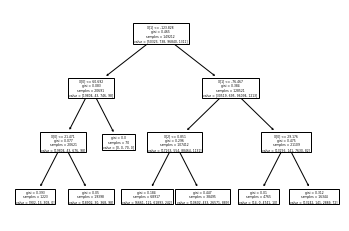

In [26]:
plot_tree(dt_model)

In [27]:
print('Accuracy of decision tree classifier on train set: {:.2f}'.format(dt_model.score(X_train, Y_train)))
print('Accuracy of decision tree classifier on test set: {:.2f}'.format(dt_model.score(X_test, Y_test)))
print('F1 score of decision tree classifier on test set: {:.2f}'.format(f1_score(Y_test, dt_model.predict(X_test), average='weighted')))

Accuracy of decision tree classifier on train set: 0.85
Accuracy of decision tree classifier on test set: 0.85
F1 score of decision tree classifier on test set: 0.83


In [28]:
from sklearn.metrics import confusion_matrix
Y_pred = dt_model.predict(X_test)
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[14208     0  7388     0]
 [   93     0   209     0]
 [ 1572     0 39889     0]
 [   77     0   513     0]]


## Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression()

In [31]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(logreg.coef_))], axis = 1)
coefficients

,0,0,1,2,3
0,LAT,0.050018,-0.039532,-0.037990,0.027504
1,LON,-0.005125,0.012075,-0.023279,0.016328
2,SOG,-0.043811,0.053635,-0.099297,0.089473
3,Heading,-0.000313,-0.000309,0.003981,-0.003360
4,acceleration,0.000076,-0.000003,-0.000049,-0.000024
5,bearing_rate,-0.000393,0.000042,0.000508,-0.000158


In [32]:
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, Y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, Y_test)))
print('F1 score of logistic regresssion classifier on test set: {:.2f}'.format(f1_score(Y_test, logreg.predict(X_test), average='weighted')))

Accuracy of logistic regression classifier on train set: 0.71
Accuracy of logistic regression classifier on test set: 0.72
F1 score of logistic regresssion classifier on test set: 0.69


In [33]:
from sklearn.metrics import confusion_matrix
Y_pred = logreg.predict(X_test)
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[ 8703     0 12891     2]
 [   67     0   232     3]
 [ 4392     0 37028    41]
 [  298     0   287     5]]


## Boosted

In [34]:
from sklearn.ensemble import AdaBoostClassifier

In [35]:
ada = AdaBoostClassifier()
ada.fit(X_train, Y_train)

AdaBoostClassifier()

In [36]:
print('Accuracy of AdaBoost classifier on train set: {:.2f}'.format(ada.score(X_train, Y_train)))
print('Accuracy of AdaBoost classifier on test set: {:.2f}'.format(ada.score(X_test, Y_test)))
print('F1 score of AdaBoost classifier on test set: {:.2f}'.format(f1_score(Y_test, ada.predict(X_test), average='weighted')))

Accuracy of AdaBoost classifier on train set: 0.86
Accuracy of AdaBoost classifier on test set: 0.86
F1 score of AdaBoost classifier on test set: 0.85


In [37]:
from sklearn.metrics import confusion_matrix
Y_pred = ada.predict(X_test)
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[15119     0  6473     4]
 [   34     0   266     2]
 [ 1358     0 40018    85]
 [   66     1   494    29]]
